<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/CS229MachineLearning/2022AndrewLectureNotes/Probset1/Prob3/Set1Problem3(d).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [149]:
import copy

In [4]:
pd.read_csv('/content/ds4_train.csv').head()

,x_1,x_2,x_3,x_4,y
0,1.0,0.0,0.992047,0.325741,2463097
1,0.0,1.0,0.470463,0.371866,645481
2,0.0,1.0,0.496533,0.289853,474123
3,0.0,1.0,0.196377,0.694672,1542136
4,0.0,1.0,0.224992,0.880809,3705439


In [3]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [261]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')

# (c)
Consider a website that wants to **predict its daily traffic**. The website owners have collected a dataset of past traffic to their website, along with some features which they think are useful in predicting the number of visitors per day. The dataset is split into train/valid/test sets and follows the same format as Datasets. We will apply **Poisson regression** to model the number of visitors per day. Note that applying Poisson regression in particular assumes that the data follows a poisson distribution whose natural parameter is a linear combination on the input featuers (i.e., $\eta = θ^Tx$. Implement Possion regression for this dataset and **use gradient ascent** to maximize the log-likelihood of $θ$.

In [262]:
train_path = "/content/ds4_train.csv"
eval_path = "/content/ds4_valid.csv"
pred_path= "/content/"

In [315]:
class PoissonRegression(LinearModel):
    """Poisson Regression.

    Example usage:
        > clf = PoissonRegression(step_size=lr)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """
    def h(self, theta, x):
      return np.exp(x@theta)

    def fit(self, x, y):
        """Run gradient ascent to maximize likelihood for Poisson regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def nextstep(theta):
          return self.step_size/x.shape[0]*x.T@(y-self.h(theta,x))
        
        theta = np.zeros(x.shape[1])
        step = nextstep(theta)
        while np.linalg.norm(step,1) > self.eps:
          theta += step
          step= nextstep(theta)
        self.theta = theta
        print(f"converged: (theta: {theta})")

        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Floating-point prediction for each input, shape (m,).
        """
        # *** START CODE HERE ***
        return self.h(self.theta,x)
        # *** END CODE HERE ***

In [325]:
import numpy as np
def main(lr, train_path = train_path, eval_path = eval_path, pred_path = pred_path):
    """Problem 3(d): Poisson regression with gradient ascent.

    Args:
        lr: Learning rate for gradient ascent.
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load training set
    x_train, y_train = load_dataset(train_path, add_intercept=False)
    x_train = add_intercept(x_train)
    clf = PoissonRegression(lr)
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    np.savetxt(pred_path+'train_pred.txt',y_train_pred)


    x_val, y_val = load_dataset(eval_path, add_intercept=False)
    x_val = add_intercept(x_val)
    y_val_pred = clf.predict(x_val)
    np.savetxt(pred_path+'val_pred.txt',y_val_pred)
    
    plt.title("prediction for train data")
    plt.plot(y_train, 'go', label = 'y_train')
    plt.plot(y_train_pred, 'rx', label = 'y_pred')
    plt.legend()
    plt.show()

    plt.title("prediction for validation data")
    plt.plot(y_val, 'go', label = 'y_val')
    plt.plot(y_val_pred, 'rx', label = 'y_pred')
    plt.legend()
    plt.show()
    return y_train_pred,y_val_pred
    # *** START CODE HERE ***
    # Fit a Poisson Regression model
    # Run on the validation set, and use np.savetxt to save outputs to pred_path
    # *** END CODE HERE ***

converged: (theta: [7.36634165 3.93318234 3.43315931 2.00016705 4.40044949])


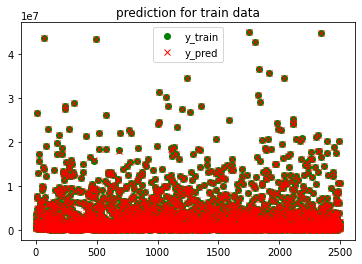

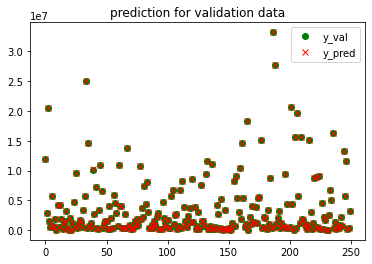

In [326]:
y_train_pred,y_val_pred = main(1e-7)

In [327]:
x_train, y_train = load_dataset(train_path, add_intercept=False)
x_val, y_val = load_dataset(eval_path, add_intercept=False)

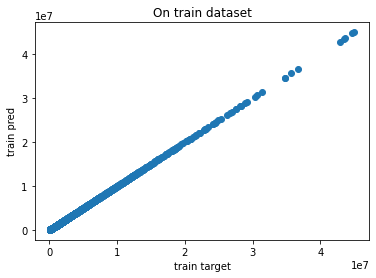

In [323]:
plt.title("On train dataset")
plt.scatter(y_train, y_train_pred)
plt.xlabel("train target")
plt.ylabel("train pred")
plt.show()

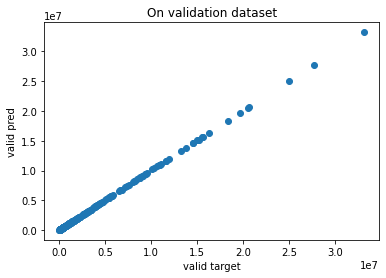

In [324]:
plt.title("On validation dataset")
plt.scatter(y_val, y_val_pred)
plt.xlabel("valid target")
plt.ylabel("valid pred")
plt.show()